In [1]:
import os
from pathlib import Path
import sys

# Set the project root relative to this notebook
project_root = Path.cwd().parent  # assumes you're inside 'notebooks/'
os.chdir(project_root)            # ensures all relative paths work from root
sys.path.append(str(project_root / "src"))  # allows `from mils_pruning import ...`


In [2]:
from mils_pruning import BinarizedMLP
from mils_pruning import train, EarlyStopping
from mils_pruning import get_mnist_data_loaders
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loaders, val_loader, test_loader = get_mnist_data_loaders(num_runs=1)
train_loader = train_loaders[0]

model = BinarizedMLP(input_shape=(10, 10), nodes_h1=32, nodes_h2=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, min_delta=0)

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    early_stopping=early_stopping,
    epochs=50,
    device=device,
    experiment_id="test01"
)



Epoch [1/50], Train Loss: 1.4160, Train Acc: 57.66%, Val Loss: 1.0587, Val Acc: 72.73%
Epoch [2/50], Train Loss: 0.9360, Train Acc: 76.71%, Val Loss: 0.8088, Val Acc: 79.77%
Epoch [3/50], Train Loss: 0.8145, Train Acc: 78.67%, Val Loss: 0.8409, Val Acc: 76.11%
Epoch [4/50], Train Loss: 0.7509, Train Acc: 80.01%, Val Loss: 0.7545, Val Acc: 79.98%
Epoch [5/50], Train Loss: 0.7178, Train Acc: 80.09%, Val Loss: 0.7585, Val Acc: 77.74%
Epoch [6/50], Train Loss: 0.6968, Train Acc: 79.81%, Val Loss: 0.6912, Val Acc: 81.05%
Epoch [7/50], Train Loss: 0.6731, Train Acc: 80.49%, Val Loss: 0.7101, Val Acc: 78.97%
Epoch [8/50], Train Loss: 0.6602, Train Acc: 80.76%, Val Loss: 0.6815, Val Acc: 79.01%
Epoch [9/50], Train Loss: 0.6331, Train Acc: 81.42%, Val Loss: 0.6628, Val Acc: 80.33%
Epoch [10/50], Train Loss: 0.6325, Train Acc: 81.11%, Val Loss: 0.6256, Val Acc: 80.78%
Epoch [11/50], Train Loss: 0.6376, Train Acc: 80.70%, Val Loss: 0.6541, Val Acc: 80.14%
Epoch [12/50], Train Loss: 0.6299, Train 

In [3]:
from mils_pruning.model import BinarizedMLP
from mils_pruning.eval import test

# Recreate model
model = BinarizedMLP(input_shape=(10, 10), nodes_h1=32, nodes_h2=32).to(device)

# Load best model
model.load_state_dict(torch.load("saved_weights/experiment_test01/best_model.pt"))
model.eval()

# Evaluate on test set
test(model, test_loader, device)


80.63

In [4]:
strategy = "min_increase"
prune_step = 1
max_removal_ratio = 0.2

In [5]:
from mils_pruning.pruning import MILSPruner
from mils_pruning import run_pruning_experiment

# Choose your hypothesis here
pruner = MILSPruner(method="bdm", strategy=strategy) 

run_pruning_experiment(
    pruner,
    model,
    test_loader,
    device,
    max_removal_ratio=max_removal_ratio,
    prune_step=prune_step,
    experiment_name="bdm_mils"
)

Pruning (bdm_mils): 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


In [6]:
from mils_pruning.pruning import MILSPruner
from mils_pruning import run_pruning_experiment

pruner = MILSPruner(method="entropy", strategy=strategy)

run_pruning_experiment(
    pruner,
    model,
    test_loader,
    device,
    max_removal_ratio=max_removal_ratio,
    prune_step=prune_step,
    experiment_name="entropy_mils"
)

Pruning (entropy_mils): 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


In [7]:
from mils_pruning.pruning import RandomPruner
from mils_pruning import run_pruning_experiment

pruner = RandomPruner()
run_pruning_experiment(
    pruner,
    model,
    test_loader,
    device,
    max_removal_ratio=max_removal_ratio,
    prune_step=prune_step,
    experiment_name="random"
)

Pruning (random): 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


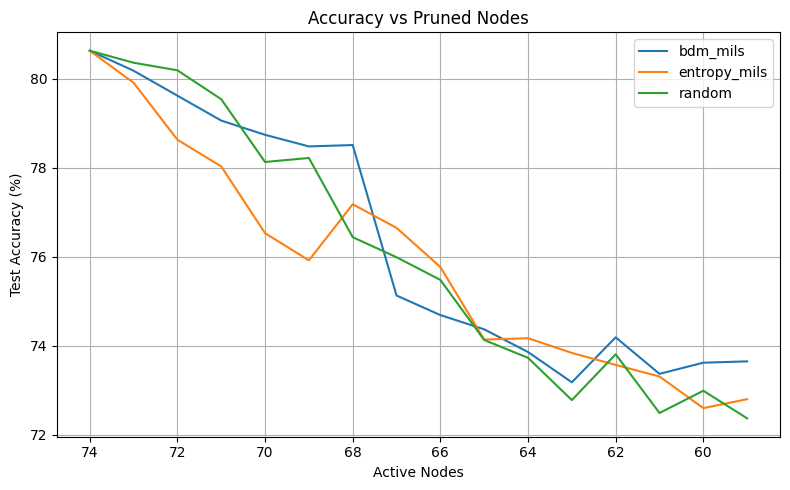

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pruning_results(experiment_names, directory="results"):
    """
    Load and plot pruning accuracy vs number of active nodes.
    
    Parameters
    ----------
    experiment_names : str or List[str]
        Name(s) of experiments (used as prefix for .npy files).
    directory : str
        Path to results directory.
    """
    if isinstance(experiment_names, str):
        experiment_names = [experiment_names]

    plt.figure(figsize=(8, 5))
    for name in experiment_names:
        accs = np.load(Path(directory) / f"{name}_accs.npy")
        nodes = np.load(Path(directory) / f"{name}_nodes.npy")
        plt.plot(nodes, accs, label=name)

    plt.xlabel("Active Nodes")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Accuracy vs Pruned Nodes")
    plt.gca().invert_xaxis()  # Higher pruning = further left
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



plot_pruning_results(["bdm_mils", "entropy_mils", "random"], directory="results")